In [2]:
from einops import rearrange, reduce, repeat

import qutip

import numpy as np
import matplotlib.pyplot as plt

In [30]:
from scipy.linalg import block_diag

In [3]:
def add_mpo( A, B, is_first = False, is_last = False):
  s0, s1, s2 = A.shape[:3]

  if is_first:
    #immutable axes are 0,2
    C = np.append(A, B, axis=1)

  elif is_last:
    #immutable axes are 0,1
    C = np.append(A, B, axis=2)

  else:
    #immutable axes are 0,2
    top = np.append( A, np.zeros((s0,B.shape[1],s2,A.shape[3])), axis=1)
    bottom = np.append(np.zeros((s0,A.shape[1],s2,B.shape[3])),B, axis =1)
    C = np.append( top, bottom, axis=3 )

  return C

In [4]:
def exp_val(cell_0, cell_1, cell_no=0):
  if not cell_no:
    return np.einsum('b c a, e e c, a b', cell_0, cell_1, atom_adag@atom_a)
  elif cell_no:
    return np.einsum('a c a, f e c, e f', cell_0, cell_1, cav_adag@cav_a)
  else:
    return np.einsum('a c a, f f c', cell_0, cell_1)


In [5]:
no_cav = 3
ac_list = list()

ac_list.append(qutip.fock_dm(2,1).full())

for i in range(no_cav):
    ac_list.append(qutip.fock_dm(3,0).full())

In [79]:
# mpo conversion and storage

mpo_0 = np.einsum('a b, c d, e f, g h-> a c e g b d f h', ac_list[0], ac_list[1], ac_list[2], ac_list[3])

u, s, v = np.linalg.svd((rearrange(mpo_0, 'a c e g b d f h-> (a b c d e f) (g h)')), full_matrices=False)
cell_0 = rearrange(np.diag(s)@v, 'c (a b)-> c a b', a=3, b=3)

u, s, v = np.linalg.svd((rearrange(u, '(a b c d e f) g -> (a b c d) (e f g)', a=2, b=2, c=3, d=3, e=3, f=3)), full_matrices=False)
cell_1 = rearrange(np.diag(s)@v, 's (e f g)-> s e g f', e=3, f=3)

u, s, v = np.linalg.svd((rearrange(u, '(a b c d) s -> (a b) (c d s)', a=2, b=2, c=3, d=3)), full_matrices=False)
cell_2 = rearrange(np.diag(s)@v, 't (c d s)-> t c s d', c=3, d=3)

cell_3 = rearrange(u, '(a b) t-> a t b', a=2, b=2)

ac_list = [cell_3, cell_2, cell_1, cell_0]

In [80]:
def svd(mpo_x):
    u, s, v = np.linalg.svd((rearrange(mpo_x, 'a c e g b d f h-> (a b c d e f) (g h)')), full_matrices=False)
    cell_0 = rearrange(np.diag(s)@v, 'c (a b)-> c a b', a=3, b=3)

    u, s, v = np.linalg.svd((rearrange(u, '(a b c d e f) g -> (a b c d) (e f g)', a=2, b=2, c=3, d=3, e=3, f=3)), full_matrices=False)
    cell_1 = rearrange(np.diag(s)@v, 's (e f g)-> s e g f', e=3, f=3)

    u, s, v = np.linalg.svd((rearrange(u, '(a b c d) s -> (a b) (c d s)', a=2, b=2, c=3, d=3)), full_matrices=False)
    cell_2 = rearrange(np.diag(s)@v, 't (c d s)-> t c s d', c=3, d=3)

    cell_3 = rearrange(u, '(a b) t-> a t b', a=2, b=2)

    return cell_3, cell_2, cell_1, cell_0

In [81]:
mpo_i = np.einsum('a t b, t c s d, s e q f, q g h-> a c e g b d f h', cell_3, cell_2, cell_1, cell_0 )

In [82]:
np.isclose(mpo_i, mpo_0).all()

True

In [84]:
rearrange(np.einsum('a b c, c d e-> a b d e', pre_mpo[0], ac_list[0]), 'a b d e-> a (b d) e').shape

(2, 40, 2)

In [75]:
def g1(t=0):
    return 1

def g2(t=0):
    return 1

def g3(t=0):
    return 1

g = 1                  #gamma
rg = g**0.5

In [105]:
dim = int(1 + no_cav + (no_cav*0.5*(no_cav+1)))
zero_mpo_matrix = np.array( list([ list([ np.zeros((3,3))])*dim ])*dim ) *0j

pre_term1 = zero_mpo_matrix
pre_term1[0][0][:][:] = np.eye(3)
pre_term1[1][1][:][:] = ad * g1()
pre_term1[2][2][:][:] = np.eye(3)
pre_term1[3][3][:][:] = np.eye(3)
pre_term1[4][4][:][:] = ad@a * g1()**2
pre_term1[5][5][:][:] = a * g1()
pre_term1[6][6][:][:] = np.eye(3)
pre_term1[7][7][:][:] = a * g1()
pre_term1[8][8][:][:] = np.eye(3)
pre_term1[9][9][:][:] = np.eye(3)

pre_term2 = zero_mpo_matrix
pre_term2[0][0][:][:] = np.eye(3)
pre_term2[1][1][:][:] = np.eye(3)
pre_term2[2][2][:][:] = ad * g2()
pre_term2[3][3][:][:] = np.eye(3)
pre_term2[4][4][:][:] = np.eye(3)
pre_term2[5][5][:][:] = ad * g2()
pre_term2[6][6][:][:] = ad@a * g2()**2
pre_term2[7][7][:][:] = np.eye(3)
pre_term2[8][8][:][:] = a * g2()
pre_term2[9][9][:][:] = np.eye(3)

post_term1 = zero_mpo_matrix
post_term1[0][0][:][:] = np.eye(3)
post_term1[1][1][:][:] = a * g1()
post_term1[2][2][:][:] = np.eye(3)
post_term1[3][3][:][:] = np.eye(3)
post_term1[4][4][:][:] = ad@a * g1()**2
post_term1[5][5][:][:] = ad * g1()
post_term1[6][6][:][:] = ad * g1()
post_term1[7][7][:][:] = np.eye(3)
post_term1[8][8][:][:] = np.eye(3)
post_term1[9][9][:][:] = np.eye(3)

post_term2 = zero_mpo_matrix
post_term2[0][0][:][:] = np.eye(3)
post_term2[1][1][:][:] = np.eye(3)
post_term2[2][2][:][:] = a * g2()
post_term2[3][3][:][:] = np.eye(3)
post_term2[4][4][:][:] = np.eye(3)
post_term2[5][5][:][:] = a * g2()
post_term2[6][6][:][:] = np.eye(3)
post_term2[7][7][:][:] = ad@a * g2()**2
post_term2[8][8][:][:] = ad * g2()
post_term2[9][9][:][:] = np.eye(3)

L_term1 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
L_term1[0][0][:][:] = np.eye(3)
L_term1[1][1][:][:] = g1() * a
L_term1[2][2][:][:] = np.eye(3)
L_term1[3][3][:][:] = np.eye(3)

L_term2 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
L_term1[0][0][:][:] = np.eye(3)
L_term1[1][1][:][:] = np.eye(3)
L_term1[2][2][:][:] = g2() * a
L_term1[3][3][:][:] = np.eye(3)

Ld_term1 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
Ld_term1[0][0][:][:] = np.eye(3)
Ld_term1[1][1][:][:] = g1() * ad
Ld_term1[2][2][:][:] = np.eye(3)
Ld_term1[3][3][:][:] = np.eye(3)

Ld_term2 = np.array( list([ list([ np.zeros((3,3))])*(no_cav+1) ])*(no_cav+1) ) *0j
Ld_term1[0][0][:][:] = np.eye(3)
Ld_term1[1][1][:][:] = np.eye(3)
Ld_term1[2][2][:][:] = g2() * ad
Ld_term1[3][3][:][:] = np.eye(3)


In [109]:
pre_mpo = list([
                -0.5 * rearrange( np.array( [ g*cd@c, rg*c, rg*c, rg*c, np.eye(2), np.eye(2), np.eye(2),np.eye(2),np.eye(2),np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(pre_term1, 'a b c d-> a c b d') , 

                rearrange(pre_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*ad, np.eye(3), np.eye(3), np.eye(3), g3()*ad, g3()*ad, g3()**2 * ad@a ] )    
])

post_mpo = list([
                -0.5 * rearrange( np.array( [ g*cd@c, rg*cd, rg*cd, rg*cd, np.eye(2), np.eye(2), np.eye(2),np.eye(2),np.eye(2),np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(post_term1, 'a b c d-> a c b d') , 

                rearrange(post_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*a, np.eye(3), np.eye(3), a*g3(), np.eye(3), g3()*a, g3()**2 * ad@a ] )   
])

L_mpo = list([
                rearrange( np.array( [ rg*c, np.eye(2), np.eye(2), np.eye(2), np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(L_term1, 'a b c d-> a c b d') , 

                rearrange(L_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*a ] ) 
])

Ld_mpo = list([
                rearrange( np.array( [ rg*cd, np.eye(2), np.eye(2), np.eye(2), np.eye(2) ] ) , 'c a b-> a c b'),

                rearrange(Ld_term1, 'a b c d-> a c b d') , 

                rearrange(Ld_term2, 'a b c d-> a c b d') ,

                np.array( [ np.eye(3), np.eye(3), np.eye(3), g3()*ad ] )
])

In [ ]:
#atom_a 
c = qutip.destroy(2).full()
#atom_a = np.eye(2)
#atom_adag
cd = qutip.destroy(2).dag().full()
#atom_adag = np.eye(2)
#cav_a 
a = qutip.destroy(3).full()
#cav_a = np.eye(3)
#cav_adag 
ad = qutip.destroy(3).dag().full()
#cav_adag = np.eye(3)

In [110]:
term1 = list([
            rearrange(np.einsum('a b c, c d e-> a b d e', pre_mpo[0], ac_list[0]), 'a b d e-> a (b d) e'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[1], ac_list[1]), 'a e b c f g-> (a e) b (c f) g'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', pre_mpo[2], ac_list[2]), 'a e b c f g-> (a e) b (c f) g'),
            rearrange(np.einsum('a b c, d c e-> a d b e', pre_mpo[3], ac_list[3]), 'a d b e-> (a d) b e'), 
])

term2 = list([
            rearrange(np.einsum('a b c, c d e-> a b d e', ac_list[0], post_mpo[0]), 'a b d e-> a (b d) e'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', ac_list[1], post_mpo[1]), 'a e b c f g-> (a e) b (c f) g'), 
            rearrange(np.einsum('a b c d, e d f g-> a e b c f g', ac_list[2], post_mpo[2]), 'a e b c f g-> (a e) b (c f) g'),
            rearrange(np.einsum('a b c, d c e-> a d b e', ac_list[3], post_mpo[3]), 'a d b e-> (a d) b e'), 
])

term3 = list([
            rearrange(np.einsum('a b c, c d e, e f g-> a b d f g', L_mpo[0], ac_list[0], Ld_mpo[0]), 'a b d f g-> a (b d f) g'),
            rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[1], ac_list[1], Ld_mpo[1]), 'a f h b c e i j-> (a f h) b (c e i) j'),
            rearrange(np.einsum('a b c d, f d e g, h g i j-> a f h b c e i j', L_mpo[2], ac_list[2], Ld_mpo[2]), 'a f h b c e i j-> (a f h) b (c e i) j'),
            rearrange(np.einsum('a b c, d c e, f e g-> a d c b g', L_mpo[3], ac_list[3], Ld_mpo[3]), 'a d c b g-> (a d c) b g')
])

In [ ]:
sum_term =

In [ ]:
np.isclose(matrc,
           rearrange(np.einsum(
           'a b c, d e b-> a d c e',
           rearrange(np.einsum('a b c, c d e-> a b d e', cell_0, Ldag_atom), 'a b d e-> a (b d) e'),
           rearrange(np.einsum('a b c, b e d-> a e c d', cell_1, Ldag_cav), 'a e c d-> a e (c d)')),
                     'a c b d-> (a c) (b d)')


           ).all()

True

In [ ]:
def drhodt(cell_0, cell_1):

  # L rho Ldag
  atom_0 = rearrange(np.einsum('a b c, c d e, e f g-> a b d f g', L_atom, cell_0, Ldag_atom), 'a b d f g-> a (b d f) g')
  cav_0 = rearrange(np.einsum('a b c, b d e, d f g-> a f c e g', L_cav, cell_1, Ldag_cav), 'a f c e g-> a f (c e g)')

  # rho H'
  atom_1 = rearrange(np.einsum('a b c, c d e-> a b d e', cell_0, post_atom), 'a b d e-> a (b d) e')
  cav_1 = rearrange(np.einsum('a b c, b e d-> a e c d', cell_1, post_cav), 'a b c d-> a b (c d)')

  # H' rho
  atom_2 = rearrange(np.einsum('a b c, c d e-> a b d e', pre_atom, cell_0), 'a b d e-> a (b d) e')
  cav_2 = rearrange(np.einsum('a b c, b e d-> a e c d', pre_cav, cell_1), 'a b c d-> a b (c d)')

  dcell_0 = add_mpo(add_mpo(atom_0, atom_1, is_first=True), atom_2, is_first=True)
  dcell_1 = add_mpo(add_mpo(cav_0, cav_1, is_last=True), cav_2, is_last=True)

  return dcell_0, dcell_1

In [ ]:
time = np.linspace(0,10,5000)
dt = time[1]
list1= list()
list2 = list()

for i in time:

  dcell_0, dcell_1 = drhodt(cell_0, cell_1)
  cell_n0 = add_mpo(cell_0, (dt*dcell_0), is_first=True)
  cell_n1 = add_mpo(cell_1, (dcell_1), is_last=True)

  list1.append( exp_val(cell_n0, cell_n1) )
  list2.append( exp_val(cell_n0, cell_n1, cell_no=1) )

  mpo_i = np.einsum('a c b, e f c-> a e b f', cell_n0, cell_n1)
  u, s, v = np.linalg.svd((rearrange(mpo_i, 'a c b d-> (a b) (c d)')), full_matrices=False)
  cell_0 = rearrange(u, '(a b) c-> a c b', a=2, b=2)
  cell_1 = rearrange(np.diag(s)@v, 'c (a b)-> a b c', a=3, b=3)

/Users/ygup3491/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


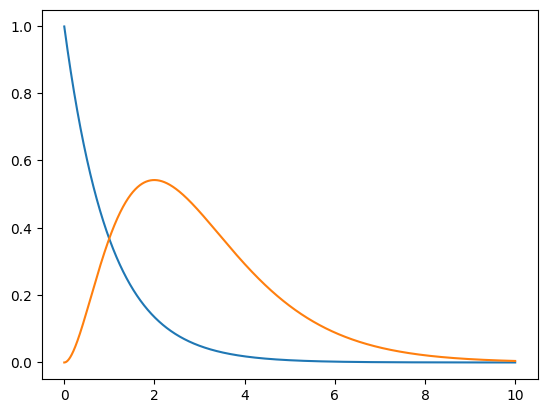

In [ ]:
plt.plot(time, list1)
plt.plot(time,list2)

#Archive

In [ ]:
# H rho

Hrho_0 = rearrange(np.einsum('a b c, c d e-> a b d e', H_atom, cell_0), 'a b d e-> a (b d) e')
Hrho_1 = rearrange(np.einsum('a b c, b e d-> a e c d', H_cav, cell_1), 'a e c d-> a e (c d)')

In [ ]:
# rho H

rhoH_0 = rearrange(np.einsum('a b c, c d e-> a b d e', cell_0, H_atom), 'a b d e-> a (b d) e')
rhoH_1 = rearrange(np.einsum('a b c, b e d-> a e c d', cell_1, H_cav), 'a b c d-> a b (c d)')

In [ ]:
dcell_0 = add_mpo(Hrho_0,-rhoH_0, is_first=True)
dcell_1 = add_mpo(Hrho_1,rhoH_1, is_last=True)

In [ ]:
matrc = np.kron((atom_a@atom_0),(cav_adag@cav_0))+ np.kron((atom_adag@atom_0),(cav_a@cav_0)) - np.kron((atom_0@atom_a),(cav_0@cav_adag))- np.kron((atom_0@atom_adag),(cav_0@cav_a))

In [ ]:
dcell_i0, dcell_i1 = drhodt(cell_0, cell_1)

In [ ]:

np.isclose( matrc, rearrange(np.einsum('a b c, d e b-> a d c e',dcell_i0, dcell_i1 ), 'a c b d-> (a c) (b d)' ) ).all()

False

In [ ]:
np.isclose(np.kron(atom_0, cav_0)- np.kron(atom_0, cav_0), rearrange(np.einsum('a b c, d e b-> a d c e', add_mpo(cell_0,-cell_0, is_first=True), add_mpo(cell_1,cell_1, is_last=True)), 'a c b d-> (a c) (b d)'))

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [ ]:
A = np.random.rand()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [ ]:
np.kron(atom_0, cav_0)-np.kron(atom_0, cav_0)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [ ]:
np.einsum('a b c, d e b-> a d c e',add_mpo(cell_0,-cell_0, is_first=True), add_mpo(cell_1,-cell_1, is_last=True) ).shape

(2, 3, 2, 3)

In [ ]:
np.isclose(np.kron((atom_0+atom_0), (cav_0+cav_0)), (np.kron(atom_0, cav_0)+np.kron(atom_0, cav_0)))

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True],
       [ True,  True,  True,  True,  True,  True]])

In [ ]:
np.isclose( np.kron(atom_0, (cav_adag@cav_0)), rearrange(np.einsum('a b c, d e b-> a d c e', cell_0, np.einsum('a d, d e c-> a e c', cav_adag, cell_1)), 'a c b d-> (a c) (b d)')).all()

True

In [ ]:
H_cav.shape

(3, 3, 2)

In [ ]:
np.isclose((np.kron((atom_a@atom_0),(cav_adag@cav_0))+ np.kron((atom_adag@atom_0),(cav_a@cav_0))), rearrange(np.einsum('a b c, d e b-> a d c e', Hrho_0, Hrho_1),'a c b d->(a c) (b d)')).all()

True

In [ ]:
np.isclose((np.kron((atom_0@atom_a),(cav_0@cav_adag))+ np.kron((atom_0@atom_adag),(cav_0@cav_a))), rearrange(np.einsum('a b c, d e b-> a d c e', rhoH_0, rhoH_1),'a c b d->(a c) (b d)')).all()

True

In [ ]:
np.isclose(np.kron(atom_a, cav_a)@np.kron(atom_0,cav_0), rearrange(np.einsum('t a, a c b, c e f, s e-> t s b f', atom_a, cell_0, cell_1, cav_a),'a c b d-> (a c) (b d)')).all()

True

In [ ]:
np.einsum('a c a c',mpo_0)

(1+0j)

In [ ]:
np.trace(np.kron(atom_0, cav_0))

(1+0j)